# This notebook is for Analyzing Enron Email Dataset (Project Email)

## Tasks to Do

1. Select emails base on keywords 
    1. Load, Clean & Parse Emails to get started
    2. Select emails based on keywords
2. Time series analysis of the emails
    1. Parse string to Datetime object for doing time series analysis
    2. Plot time series
3. Email Clustering
    1. Rremoving stopwords and vectorize the content
    2. Run KMeans on the Data
    3. Find important keywords from for each clusters
    4. Find topics from the text (??)
4. Sentiment Analysis
    1. Do Sentiment analysis on the email texts
    2. plot sentiments 


#### Importing modules

In [1]:
import pandas as pd
import requests
import matplotlib.pyplot as plt
import numpy as np
from datetime import datetime
from textblob import TextBlob
from sklearn.feature_extraction.text import TfidfVectorizer, ENGLISH_STOP_WORDS
from sklearn.cluster import KMeans, MiniBatchKMeans
import re

import spacy
from spacytextblob.spacytextblob import SpacyTextBlob
from nltk.sentiment import SentimentIntensityAnalyzer
import text2emotion as te


from parse_utils import parse_raw_message, parse_into_emails, parse_raw_message
from plot_utils import top_mean_feats, top_feats_per_cluster, plot_tfidf_classfeats_h
plt.rcParams["figure.figsize"] = (20,8) #Setting global parameters for plots


[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/facevoid/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /Users/facevoid/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     /Users/facevoid/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


#### Reading Data from the directory

In [2]:
project_email_df = pd.read_csv('processed_data/parsed_project_emails.csv')


#### Parsing Date String to (yyyy-mm-dd hh:mm:ss)

In [3]:
# Sample for parsing
datetime_object = datetime.strptime('Thu, 31 Aug 2000 05', '%a, %d %b %Y %H') 
print(datetime_object)

2000-08-31 05:00:00


In [4]:
def parse_date(row):
    date_str = row['date']
    try:
        datetime_object = datetime.strptime(date_str, '%a, %d %b %Y %H')
    except:
        return None
    return datetime_object

In [5]:
#Parsing dates for all emails
project_email_df['date_converted'] = project_email_df.apply(parse_date, axis = 1)

In [6]:
#Ignore emails that failed in date conversion
project_email_df.dropna(inplace =True)

In [7]:
#Sample of Date Conversion
project_email_df.date_converted = pd.to_datetime(project_email_df.date_converted, errors = 'coerce')
project_email_df['date_converted']

1      2000-09-11 02:00:00
5      2001-03-26 02:00:00
7      2001-03-19 00:00:00
9      2001-03-07 08:00:00
13     2001-02-27 00:00:00
               ...        
8890   2001-08-06 11:00:00
8891   2001-06-29 08:00:00
8892   2001-06-25 07:00:00
8893   2001-06-20 14:00:00
8894   2001-12-11 09:00:00
Name: date_converted, Length: 7870, dtype: datetime64[ns]

<AxesSubplot:xlabel='date_converted'>

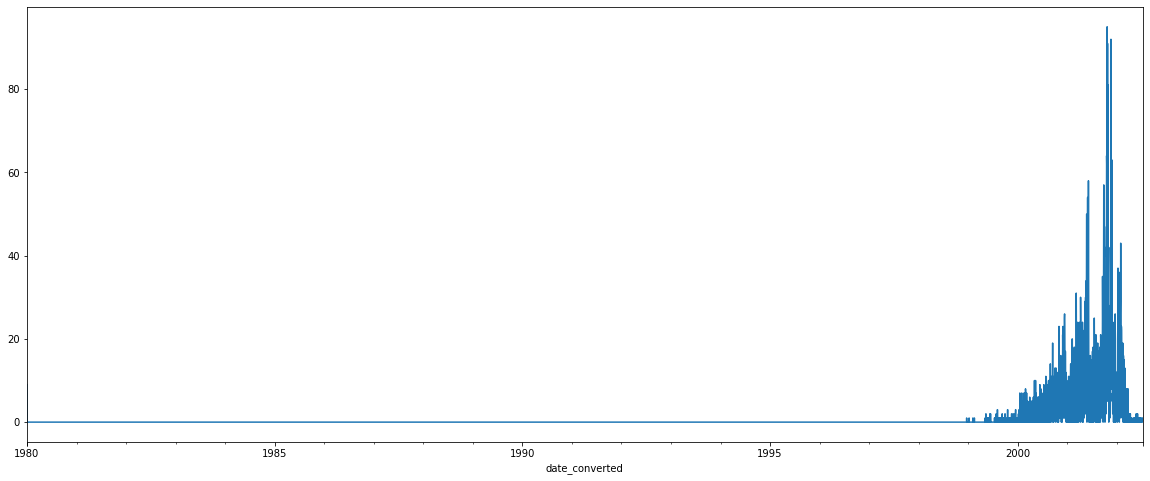

In [8]:
# Email Timelines (change the parameter in the last line to get timeline datewise (D), monthwise (M), yearwise (Y))
plt.rcParams["figure.figsize"] = (20,8)
project_email_df = project_email_df.set_index('date_converted') 
project_email_df.sort_index(inplace = True)
project_email_df.groupby(pd.Grouper(freq='D')).size().plot()

In [9]:
# Select Emails after the year 2000 to get a nice plot
project_email_df['parsed_date'] = project_email_df.index
mask = (project_email_df['parsed_date'] > '2000-01-01') & (project_email_df['parsed_date'] < '2002-04-01')
project_email_df = project_email_df.loc[mask]

<AxesSubplot:xlabel='date_converted'>

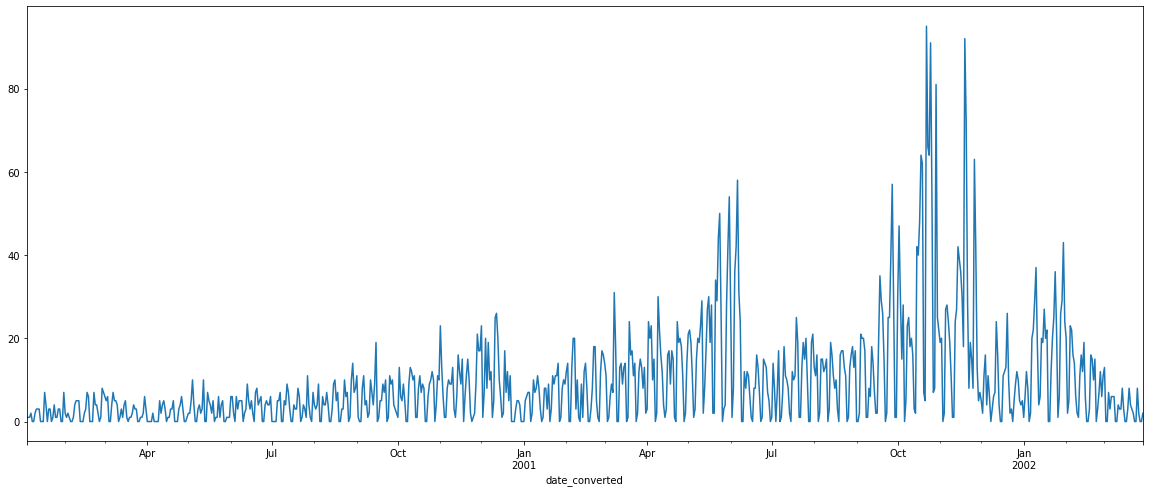

In [10]:

project_email_df.groupby(pd.Grouper(freq='D')).size().plot()

## Cluster Emails 

In [11]:
# Some note on min_df and max_df
# max_df=0.5 means "ignore all terms that appear in more then 50% of the documents"
# min_df=2 means "ignore all terms that appear in less then 2 documents"
stopwords = ENGLISH_STOP_WORDS.union(['ect', 'hou', 'com', 'recipient'])
vect = TfidfVectorizer(analyzer='word', stop_words=stopwords, max_df=0.3, min_df=2)

X = vect.fit_transform(project_email_df.body)
features = vect.get_feature_names()

In [44]:
n_clusters = 5
batch_size = 500
clf = MiniBatchKMeans(n_clusters=n_clusters, init_size=1000, batch_size=batch_size, max_iter=100)  
clf.fit(X)
labels = clf.fit_predict(X)


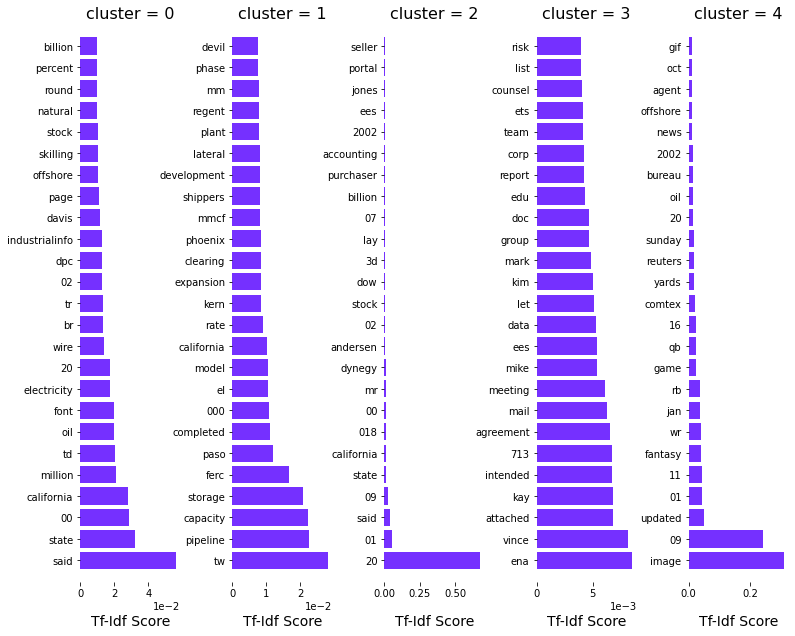

In [45]:
plot_tfidf_classfeats_h(top_feats_per_cluster(X, labels, features, 0.1, 25))


## Sentiment Analysis
1. Extracting Aspects [based on POS, can be used ml] , Sentiments & Tones from Texts
2. Create CSV with all extracted information

In [14]:
mask = project_email_df['body'].str.len() < 1000
project_email_filtered_df = project_email_df[mask]

In [15]:
# nlp = spacy.load('en_core_web_sm')
nlp = spacy.load('en_core_web_trf')
nlp.add_pipe('spacytextblob')


#### NLTK Sentiment

In [16]:
nltk_sentiment_analyzer = SentimentIntensityAnalyzer()

In [17]:
def get_aspect_based_sentiment_from_spacy(spacy_doc):
    descriptive_term = ''
    target = ''
    for token in doc:
        if token.dep_ == 'nsubj' and token.pos_ == 'NOUN':
            target = token.text
        if token.pos_ == 'ADJ':
            prepend = ''
            for child in token.children:
                if child.pos_ != 'ADV':
                    continue
                prepend += child.text + ' '
            descriptive_term = prepend + token.text
    return {'nlp_document': doc,
                    'aspect': target,
                    'description': descriptive_term,
                    'doc_polarity': doc._.polarity,
                    'doc_subjectivity': doc._.subjectivity,
                    'doc_entities': doc.ents,
                    'doc': str(doc)
                    }

In [18]:
sentiments = []
bodies = []
dates = []
spacy_sentiments = []
nltk_sentiments = []

analyzed_texts = []

for index, row in project_email_filtered_df.iterrows():
    
    body = row['body']
    #polarity from spacy and text blob
    doc = nlp(body)
    analyzed_text = get_aspect_based_sentiment_from_spacy(doc)
    
    #NLTK sentiment
    nltk_sentiment = nltk_sentiment_analyzer.polarity_scores(body)
    analyzed_text['nltk_sentiment'] = nltk_sentiment
    #text2emotion
#     analyzed_text['emotion'] = te.get_emotion(body)
    
    analyzed_text['date'] = row['parsed_date']
    
    analyzed_texts.append(analyzed_text)
    

In [19]:
analyzed_texts_df = pd.DataFrame.from_dict(analyzed_texts)

In [20]:
analyzed_texts_df

,nlp_document,aspect,description,doc_polarity,doc_subjectivity,doc_entities,doc,nltk_sentiment,date
0,"(Louise, -, If, you, are, back, in, Houston, I...",,,0.000000,0.000000,"((Louise), (Houston), (Mark))",Louise - If you are back in Houston I'd like t...,"{'neg': 0.0, 'neu': 0.825, 'pos': 0.175, 'comp...",2000-01-04 02:00:00
1,"(Clayton, ,, guarantees, bank, nad, commercial...",story,Russian,0.028125,0.077232,"((Clayton), (OPIC), (US), (OPIC), (Brad, Blesi...","Clayton , guarantees bank nad commercial trans...","{'neg': 0.059, 'neu': 0.889, 'pos': 0.052, 'co...",2000-01-06 06:00:00
2,"(geoff.pollard@enron.com, ,, jeff.dasovich@enr...",letter,next,0.133750,0.353750,"((Frank), (Friday), (PG&E), (Geoff, Pollard), ...","geoff.pollard@enron.com , jeff.dasovich@enron....","{'neg': 0.047, 'neu': 0.834, 'pos': 0.119, 'co...",2000-01-10 04:00:00
3,"(Attached, is, a, draft, of, the, Vega, VaR, i...",projects,current,0.101918,0.448580,"((tomorrow), (IT), (Jonathan, Le), (two), (IT)...",Attached is a draft of the Vega VaR implement ...,"{'neg': 0.045, 'neu': 0.909, 'pos': 0.046, 'co...",2000-01-10 07:00:00
4,"(benjamin.rogers@enron.com, benjamin.rogers@en...",Update,,-0.083333,0.216667,"((Linda), (Tom), (Moodys), (Enron), (Enron), (...",benjamin.rogers@enron.com benjamin.rogers@enro...,"{'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound...",2000-01-11 01:00:00
...,...,...,...,...,...,...,...,...,...
1942,"(Thanks, ds, -----Original, Message-----, I, t...",conservation,last,0.141942,0.374656,"((California), (California), (last, year))",Thanks ds -----Original Message----- I thought...,"{'neg': 0.032, 'neu': 0.776, 'pos': 0.192, 'co...",2002-03-19 10:00:00
1943,"(Currently, ,, Transwestern, is, considering, ...",,Mexican,0.167273,0.450909,"((Transwestern), (TransPecos), (Transwestern),...","Currently , Transwestern is considering the Tr...","{'neg': 0.0, 'neu': 0.912, 'pos': 0.088, 'comp...",2002-03-20 14:00:00
1944,"(The, Rate, Case, Refund, project, is, going, ...",meeting,happy,0.226474,0.508077,"((Rita, Bianchi), (Raetta), ($, 2.4, million),...",The Rate Case Refund project is going extremel...,"{'neg': 0.105, 'neu': 0.782, 'pos': 0.113, 'co...",2002-03-20 15:00:00
1945,"(-----Original, Message-----, Richard, said, i...",things,little,0.050487,0.583766,"((Richard), (FERC), (SWG), (Phoenix, ROW), (8,...",-----Original Message----- Richard said if the...,"{'neg': 0.044, 'neu': 0.917, 'pos': 0.039, 'co...",2002-03-25 12:00:00


In [21]:
from spacy import displacy



In [30]:
entities = [ 'EVENT', 'FAC', 'GPE', 'LANGUAGE', 'LAW', 'LOC',
            'MONEY', 'NORP', 'ORG', 'PERCENT', 'PERSON', 'PRODUCT', 'QUANTITY',  'WORK_OF_ART']
for index, row in analyzed_texts_df[:100].iterrows():

    if len(row['aspect']) > 0 and len(row['description']) > 0:
        if row['doc_polarity'] > 0.3 or row['doc_polarity'] < -0.3:
#             print('index ', index)
            for column in analyzed_texts_df.columns:
                if column == 'nlp_document':
                    displacy.render(row[column], options = {'ents': entities}, style="ent" )
                    continue
                if column == 'doc':
                    continue
                print(column + ' == > '+ str(row[column]))
            print('\n')

aspect == > guys
description == > tremendous
doc_polarity == > 0.31190476190476196
doc_subjectivity == > 0.5142857142857142
doc_entities == > (Vince, Thursday AM, Structuring, Research, Research, Research, Dale Vince J Kaminski, Dale, Vince)
nltk_sentiment == > {'neg': 0.0, 'neu': 0.757, 'pos': 0.243, 'compound': 0.975}
date == > 2000-01-11 09:00:00




aspect == > platform
description == > happy
doc_polarity == > 0.36538461538461536
doc_subjectivity == > 0.6051282051282051
doc_entities == > (Dusty, Bethesda, the last nine months or so, MetLife, Mark)
nltk_sentiment == > {'neg': 0.0, 'neu': 0.804, 'pos': 0.196, 'compound': 0.9848}
date == > 2000-01-24 08:00:00




aspect == > people
description == > great
doc_polarity == > 0.37500000000000006
doc_subjectivity == > 0.5375
doc_entities == > (Jennifer Fraser, today, 3-5pm), tomorrow, 3-5pm))
nltk_sentiment == > {'neg': 0.0, 'neu': 0.844, 'pos': 0.156, 'compound': 0.9153}
date == > 2000-02-17 05:00:00




aspect == > roommates
description == > NO
doc_polarity == > 0.33749999999999997
doc_subjectivity == > 0.2888888888888889
doc_entities == > (Jeff, Aiaz, Anil, Kelly)
nltk_sentiment == > {'neg': 0.041, 'neu': 0.791, 'pos': 0.168, 'compound': 0.8485}
date == > 2000-02-17 14:00:00




aspect == > son
description == > Best
doc_polarity == > 0.43333333333333335
doc_subjectivity == > 0.6333333333333333
doc_entities == > (Nick, Stanford, Parents' Weekend, Stanford, Friday through Sunday this week, the weekend, Friday, Enron, Vince, Vince, Giuseppe, Stanford, Nick)
nltk_sentiment == > {'neg': 0.0, 'neu': 0.797, 'pos': 0.203, 'compound': 0.9823}
date == > 2000-02-22 18:00:00




aspect == > group
description == > great
doc_polarity == > 0.35287655971479504
doc_subjectivity == > 0.5174125874125873
doc_entities == > (Gosnell, yesterday, Kim Theriot)
nltk_sentiment == > {'neg': 0.022, 'neu': 0.716, 'pos': 0.262, 'compound': 0.9927}
date == > 2000-03-03 02:00:00




aspect == > projects
description == > ongoing
doc_polarity == > 0.5214285714285715
doc_subjectivity == > 0.6214285714285713
doc_entities == > (Corporate Research, Enron, Rodney Greene)
nltk_sentiment == > {'neg': 0.0, 'neu': 0.647, 'pos': 0.353, 'compound': 0.9868}
date == > 2000-03-12 14:00:00




aspect == > project
description == > major
doc_polarity == > 0.30156249999999996
doc_subjectivity == > 0.50625
doc_entities == > (Katie, Aggie, a hectic week, Thursday, Denver, Thursday, afternoon, Denver, all day, Friday, Houston, Saturday, Denver, Friday, night, the Nobel Prize, Gerald)
nltk_sentiment == > {'neg': 0.0, 'neu': 0.843, 'pos': 0.157, 'compound': 0.9464}
date == > 2000-03-29 01:00:00




aspect == > thoughts
description == > Good
doc_polarity == > 0.4533333333333333
doc_subjectivity == > 0.52
doc_entities == > (John, Wednesday, Thursday, this week, tomorrow, Vince, Enron North America Corp., Vince, Keane, 5-10 minutes, John x3-3830 PS, Boston, this weekend, Northern Light, Cambridge)
nltk_sentiment == > {'neg': 0.0, 'neu': 0.865, 'pos': 0.135, 'compound': 0.9065}
date == > 2000-04-10 10:00:00




Text(0, 0.5, 'Sentiment')

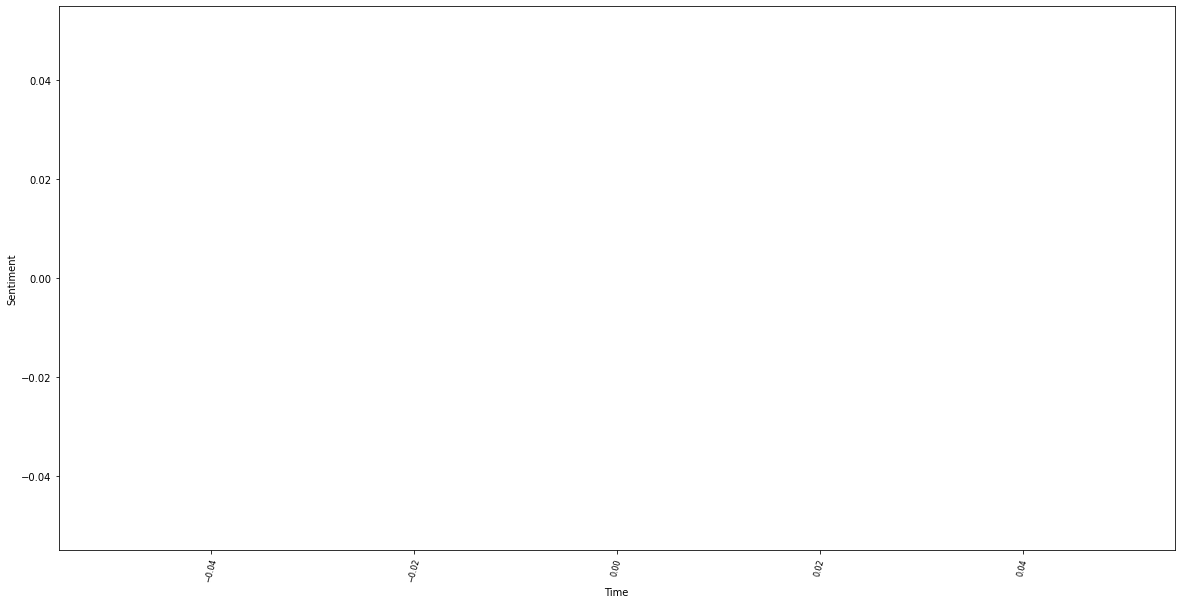

In [23]:
fig = plt.figure(figsize=(20, 10))
ax = fig.add_subplot(111)
plt.xticks(rotation=75, fontsize=8)
ax.plot(dates, sentiments, marker='o', color = 'green' )

plt.xlabel('Time')
plt.ylabel('Sentiment')

In [39]:
analyzed_text_df['doc'] = analyzed_text_df['doc'].apply(lambda x: x.strip())


In [42]:
analyzed_text_df = analyzed_texts_df.drop_duplicates(subset=['doc'])

In [43]:
entities = [ 'EVENT', 'FAC', 'GPE', 'LANGUAGE', 'LAW', 'LOC',
            'MONEY', 'NORP', 'ORG', 'PERCENT', 'PERSON', 'PRODUCT', 'QUANTITY',  'WORK_OF_ART']

doc_set = set()
for index, row in analyzed_texts_df[:1000].iterrows():
    for ent in row['nlp_document'].ents:
        if ent.label_ == 'FAC':
#             displacy.render(row['nlp_document'], options = {'ents': entities}, style="ent" )
            if row['doc'].strip() in doc_set:
                continue
            doc_set.add(row['doc'].strip())
            for column in analyzed_texts_df.columns:
                if column == 'nlp_document':
                    displacy.render(row[column], options = {'ents': entities}, style="ent" )
                    continue
                if column == 'doc':
                    continue
                print(column + ' == > '+ str(row[column]))
            print('\n')
        

aspect == > 
description == > significant
doc_polarity == > 0.375
doc_subjectivity == > 0.875
doc_entities == > (Gulf Coast Operations, 584, Elba)
nltk_sentiment == > {'neg': 0.0, 'neu': 0.943, 'pos': 0.057, 'compound': 0.2023}
date == > 2000-01-17 05:00:00




aspect == > contract
description == > possible
doc_polarity == > 0.07916666666666666
doc_subjectivity == > 0.18611111111111112
doc_entities == > (IGS, IGS, TW, one, 3%, $15 million, 2%, $10 million, Southern, the Gallup Expansion, 0.205, 25 , 000 Dth, 5 years, 15%, $6 , 270, 625, IGS, $188 , 118.75, James Centilli)
nltk_sentiment == > {'neg': 0.02, 'neu': 0.88, 'pos': 0.1, 'compound': 0.9217}
date == > 2000-02-22 09:00:00




aspect == > 
description == > few
doc_polarity == > 0.06428571428571428
doc_subjectivity == > 0.45595238095238094
doc_entities == > (Tino, earlier today, Pueblo, a few minutes, Kevin, Lorraine, the SW Power Pool)
nltk_sentiment == > {'neg': 0.0, 'neu': 0.934, 'pos': 0.066, 'compound': 0.6486}
date == > 2000-02-29 05:00:00




aspect == > section
description == > specific
doc_polarity == > 0.18333333333333335
doc_subjectivity == > 0.5958333333333333
doc_entities == > (the Bammel Compression Turnkey Construction Agreement, Project Looper, Project Coca-Cola, 1, 2, 3, Albuquerque, tommorrow, Compression Services)
nltk_sentiment == > {'neg': 0.043, 'neu': 0.791, 'pos': 0.166, 'compound': 0.9578}
date == > 2000-03-13 09:00:00




aspect == > 
description == > sure
doc_polarity == > 0.025
doc_subjectivity == > 0.43277777777777776
doc_entities == > (the Media News Confirmation, one, ENA, KPM Lasara L.P., Swaption, ENA, Counterparty, KPM Lasara L.P., Kafus, Joe Jure, 30658, Dick Robinson, 36657, KPM, Bob Crane, tomorrow, Gordon Heaney, 58175, Friday, Jarrod)
nltk_sentiment == > {'neg': 0.046, 'neu': 0.862, 'pos': 0.092, 'compound': 0.8078}
date == > 2000-04-26 09:00:00




aspect == > saltwater
description == > 
doc_polarity == > 0.05
doc_subjectivity == > 0.175
doc_entities == > (Bill, earlier today, Wednesday, morning, Eric Gillaspie, Enron Building, 3886, Ann Elizabeth White, Bill, Gillette, Dominion, about 6 months, Gerald Lofton's, Bill)
nltk_sentiment == > {'neg': 0.01, 'neu': 0.921, 'pos': 0.069, 'compound': 0.8431}
date == > 2000-06-05 10:00:00




aspect == > opposition
description == > other
doc_polarity == > 0.0288510101010101
doc_subjectivity == > 0.3981376262626263
doc_entities == > (Jeff Dasovich, Sempra, Imperial Irrigation, Mexico, Mexicali, Sempra LDC, San Diego, PG&E, Otay Mesa, Rosarita, California, CPUC, TURN, ORA)
nltk_sentiment == > {'neg': 0.018, 'neu': 0.919, 'pos': 0.063, 'compound': 0.6486}
date == > 2000-06-14 09:00:00




aspect == > deal
description == > own
doc_polarity == > 0.12142857142857143
doc_subjectivity == > 0.3880952380952381
doc_entities == > (Last week, ENA, 50%, West Texas, 50%, Wyoming, NBP, about $28 million, Project 20/20)
nltk_sentiment == > {'neg': 0.0, 'neu': 0.9, 'pos': 0.1, 'compound': 0.8074}
date == > 2000-06-29 07:00:00




aspect == > investigation
description == > difficult
doc_polarity == > 0.05000000000000001
doc_subjectivity == > 0.7444444444444445
doc_entities == > (today, Pontap Station, first, 18 feet)
nltk_sentiment == > {'neg': 0.068, 'neu': 0.932, 'pos': 0.0, 'compound': -0.6059}
date == > 2000-07-12 09:00:00




aspect == > work
description == > physical
doc_polarity == > 0.09761904761904762
doc_subjectivity == > 0.36230158730158735
doc_entities == > (Robert, Merrick, Ralph Townsend, Forerunner, House Creek, Ken Robert Walker@ECT, Jeff, Ken, Robert Walker, Merrick, Merrick, Merrick, Bob)
nltk_sentiment == > {'neg': 0.012, 'neu': 0.889, 'pos': 0.099, 'compound': 0.9042}
date == > 2000-07-20 10:00:00




aspect == > afternoon
description == > good
doc_polarity == > 0.16666666666666666
doc_subjectivity == > 0.5916666666666667
doc_entities == > (Friday am, this week, Herman Manis Mann, Lisa Bills, Roseann Engeldorf, Kay Mann, Thursday, Friday, Karen E Carter Roger/Herman, Ben Jacoby's, four, West LB, Austin, West LB, Thursday or Friday of this week)
nltk_sentiment == > {'neg': 0.015, 'neu': 0.886, 'pos': 0.099, 'compound': 0.886}
date == > 2000-08-02 04:00:00




aspect == > 
description == > electronic
doc_polarity == > 0.4
doc_subjectivity == > 0.575
doc_entities == > (Lisa, WestLB, SA, 8, LM6000s, Kay Mann, ENA, LM6000, GE, Humberto Cubillos, ENA, Lisa Bills, WestLB, Kevin Joyce, ESA, Herman Manis, ENA, WestLB, MHI, LM6000, Kay, Humberto, Kevin Joyce, MHI, Rose)
nltk_sentiment == > {'neg': 0.0, 'neu': 0.953, 'pos': 0.047, 'compound': 0.8126}
date == > 2000-08-10 10:00:00




aspect == > scope
description == > further
doc_polarity == > 0.0
doc_subjectivity == > 0.5
doc_entities == > (Bill, Pat - Attached, Lost Creek, yesterday, CIG/WIC, Lost Creek, Chris Sonneborn)
nltk_sentiment == > {'neg': 0.061, 'neu': 0.908, 'pos': 0.031, 'compound': -0.3182}
date == > 2000-08-17 02:00:00




aspect == > people
description == > too much
doc_polarity == > 0.09615384615384617
doc_subjectivity == > 0.2814102564102564
doc_entities == > (First, Scott, Australian, this Wednesday, Galleria Ruggles, one, Hollis, Second, William, every other day, William, 6 each day, Mary)
nltk_sentiment == > {'neg': 0.03, 'neu': 0.823, 'pos': 0.147, 'compound': 0.9294}
date == > 2000-08-28 02:00:00




aspect == > people
description == > too much
doc_polarity == > 0.21562499999999998
doc_subjectivity == > 0.3380208333333334
doc_entities == > (43, Scott, Mary Tana Jones, Hollis, Mary Cook, First, Scott, Australian, this Wednesday, Galleria Ruggles, one, Hollis, Second, Mark, William, every other day, William, 6, each day, Mary)
nltk_sentiment == > {'neg': 0.02, 'neu': 0.834, 'pos': 0.145, 'compound': 0.9625}
date == > 2000-08-28 09:00:00




aspect == > contact
description == > internal
doc_polarity == > -0.033130411255411246
doc_subjectivity == > 0.3865891053391053
doc_entities == > (Bill Olson, NMOCD, this afternoon, Equilon, Equilon, Jal Basin Station, Jal, NM, H2A., H2A, KEI, Bill, Equiva, Equilon)
nltk_sentiment == > {'neg': 0.011, 'neu': 0.973, 'pos': 0.015, 'compound': 0.1217}
date == > 2000-09-06 09:00:00




aspect == > projects
description == > further
doc_polarity == > 0.016666666666666666
doc_subjectivity == > 0.2777777777777778
doc_entities == > (I-45, Sunday, I-10, US 59, Two, Pierce/Dallas, McKinney, McKinney, Pierce/Dallas, January 18 , 2001, Allen Parkway, The Downtown District)
nltk_sentiment == > {'neg': 0.0, 'neu': 0.979, 'pos': 0.021, 'compound': 0.4215}
date == > 2000-09-29 09:00:00




aspect == > pace
description == > interested
doc_polarity == > 0.16458333333333333
doc_subjectivity == > 0.34791666666666665
doc_entities == > (Pac Bell Park, Jack Walklet, Sebastian Teunissen, Haas School of Business, University of California, California, USA)
nltk_sentiment == > {'neg': 0.0, 'neu': 0.852, 'pos': 0.148, 'compound': 0.9413}
date == > 2000-10-02 04:00:00




aspect == > meters
description == > fit
doc_polarity == > 0.46666666666666673
doc_subjectivity == > 0.44999999999999996
doc_entities == > (Entex, Alkire Lake, 2004, Venetian Estate, 2133, Sugarland, 2132, Smith Tap city gate, 2126, Edgewood, 2046, Richmond, 2116, Molly)
nltk_sentiment == > {'neg': 0.0, 'neu': 0.791, 'pos': 0.209, 'compound': 0.926}
date == > 2000-10-03 02:00:00




aspect == > things
description == > damn
doc_polarity == > 0.17148148148148146
doc_subjectivity == > 0.5115740740740741
doc_entities == > (Germany, JD, Corey, one, Bayou Park, Ingrid, two years, Vandy, Jim, 2, around Nov. 4, Vanderbilt, Nashville, TN, Chad)
nltk_sentiment == > {'neg': 0.069, 'neu': 0.874, 'pos': 0.057, 'compound': -0.4694}
date == > 2000-10-03 04:00:00




aspect == > times
description == > more
doc_polarity == > 0.18269230769230768
doc_subjectivity == > 0.4839743589743591
doc_entities == > (Caesar Pelli, Enron, first, two, Antioch Park, Park, 2, first, Jeff Koons, Antioch Park, Gensler, 3, 40, Koons, Skilling/Lay, Lea)
nltk_sentiment == > {'neg': 0.0, 'neu': 0.981, 'pos': 0.019, 'compound': 0.4404}
date == > 2000-10-23 10:00:00




aspect == > trip
description == > same
doc_polarity == > 0.06607142857142859
doc_subjectivity == > 0.31741071428571427
doc_entities == > (Lee Johnson, S&S, Kent, Kent, Paul Pipitone, ABB, Kay, Phase II Turbo Park, Pleasanton Local Reliability Facility LLC)
nltk_sentiment == > {'neg': 0.018, 'neu': 0.803, 'pos': 0.179, 'compound': 0.9607}
date == > 2000-10-23 11:00:00




aspect == > plants
description == > new
doc_polarity == > 0.09735930735930735
doc_subjectivity == > 0.4805627705627705
doc_entities == > (Kevin Hyatt, 10 year, No. Americal, NERC, MAIN, WSCC, KH)
nltk_sentiment == > {'neg': 0.09, 'neu': 0.897, 'pos': 0.013, 'compound': -0.8422}
date == > 2000-10-24 07:00:00




aspect == > meeting
description == > firm
doc_polarity == > 0.012500000000000004
doc_subjectivity == > 0.16250000000000003
doc_entities == > (Project Columbia, Thursday , November 2, Mt. Bachelor Conference Room, BPA, the 153 MW, Big Eddy, Longview, Thursday , November 2 p.m., BPA, URS, Lloyd Center, BPA, 249 MW, 600 MW, Longview, Laura)
nltk_sentiment == > {'neg': 0.018, 'neu': 0.962, 'pos': 0.02, 'compound': 0.0772}
date == > 2000-10-31 04:00:00




aspect == > guys
description == > first
doc_polarity == > 0.3015625
doc_subjectivity == > 0.5447916666666667
doc_entities == > (Chris, this week, tonight, the first five minutes, Jimmy Beans, Jackie)
nltk_sentiment == > {'neg': 0.0, 'neu': 0.926, 'pos': 0.074, 'compound': 0.743}
date == > 2000-11-13 03:00:00




aspect == > document
description == > Best
doc_polarity == > 0.13846153846153847
doc_subjectivity == > 0.41581196581196583
doc_entities == > (morning, Canada, Whitehorse, Yukon, Canada, ANGTS, Canada, Ottawa, Canada, Foothills, ANGTS, Alaska, Canada, Bruce - Backgrounder)
nltk_sentiment == > {'neg': 0.046, 'neu': 0.812, 'pos': 0.142, 'compound': 0.9363}
date == > 2000-11-22 04:00:00




aspect == > 
description == > light
doc_polarity == > 0.30416666666666664
doc_subjectivity == > 0.5208333333333334
doc_entities == > (a week and a half, Houston Street, today, Sapient, Houston Street, Sapient, Houston Street, Sapient, as of last week, Houston Street, Houston Street, 15 January, light years, TrueQuote)
nltk_sentiment == > {'neg': 0.044, 'neu': 0.91, 'pos': 0.046, 'compound': 0.3031}
date == > 2000-11-28 06:00:00




aspect == > 
description == > actual
doc_polarity == > 0.0
doc_subjectivity == > 0.1
doc_entities == > (Guido Caranti@ENRON_DEVELOPMENT, Eric Groves@ECT, four, PDVSA, Jose LNG, 56302, Emilio Vicens, 66014, Guido Caranti)
nltk_sentiment == > {'neg': 0.0, 'neu': 0.856, 'pos': 0.144, 'compound': 0.7096}
date == > 2000-11-30 10:00:00




aspect == > approval
description == > further
doc_polarity == > 0.0
doc_subjectivity == > 0.45
doc_entities == > (Jim, Project Crane, Board, tomorrow, Mark Senior Counsel, ENA)
nltk_sentiment == > {'neg': 0.0, 'neu': 0.909, 'pos': 0.091, 'compound': 0.6597}
date == > 2000-12-11 03:00:00




aspect == > Attachment
description == > additional
doc_polarity == > 0.25
doc_subjectivity == > 0.5125
doc_entities == > (WestLB, TurboPark, 1, Fountain Valley, Kay All, two, six, the Fountain Valley Project, Mike Storm)
nltk_sentiment == > {'neg': 0.0, 'neu': 0.926, 'pos': 0.074, 'compound': 0.7506}
date == > 2000-12-11 07:00:00




aspect == > driver
description == > Many
doc_polarity == > 0.35
doc_subjectivity == > 0.35
doc_entities == > (Frank, Enron, 3, Thursday, night, Vince, Vince, Thursday, Houston-Bush, Thurs night, Frank, Francis X. Diebold, University of Pennsylvania, Philadelphia, PA)
nltk_sentiment == > {'neg': 0.0, 'neu': 0.901, 'pos': 0.099, 'compound': 0.8955}
date == > 2000-12-18 00:00:00




aspect == > thing
description == > forward
doc_polarity == > 0.125765306122449
doc_subjectivity == > 0.702749433106576
doc_entities == > (John Nowlan, James A Hughes@ENRON_DEVELOPMENT, Dabhol, one, a few minutes, Jim)
nltk_sentiment == > {'neg': 0.094, 'neu': 0.742, 'pos': 0.164, 'compound': 0.659}
date == > 2000-12-18 05:00:00




aspect == > status
description == > 
doc_polarity == > 0.10000000000000002
doc_subjectivity == > 0.20000000000000004
doc_entities == > (Chris, Azurix, Calpine, Amanda Martin, Garrisson, LV, Regards Delainey)
nltk_sentiment == > {'neg': 0.0, 'neu': 0.759, 'pos': 0.241, 'compound': 0.8937}
date == > 2000-12-29 03:00:00




aspect == > banks
description == > -----Original
doc_polarity == > 0.3625
doc_subjectivity == > 0.4791666666666667
doc_entities == > (Lee, Jody, Enron, Fountain Valley, Enron, ESA, Kay Kay, 6, Fountain Valley Project, 4, LV Cogen Expansion, Fountain Valley, 6, 2, LV, 4, Lee, E-Next Generation LLC, Jody Pierce, EB 2480, Houston, 77002)
nltk_sentiment == > {'neg': 0.037, 'neu': 0.865, 'pos': 0.098, 'compound': 0.8755}
date == > 2001-01-03 03:00:00




aspect == > contact
description == > additional
doc_polarity == > 0.22681818181818178
doc_subjectivity == > 0.622979797979798
doc_entities == > (Bonnie, Friday, Enron, Henwood, Henwood, Indian, Enron, Indian, Dabhol, Henwood, Henwood, Henwood, Enron, Enron, Dabhol Power Corp., Enron India, Enron, North America, Henwood, Robert Schenck, Australia, Henwood Energy Services , Inc., 26, Wayville, SA, 5034, Australia, 2710, Gateway Oaks Drive, 300, Sacramento, CA, 95833)
nltk_sentiment == > {'neg': 0.0, 'neu': 0.917, 'pos': 0.083, 'compound': 0.875}
date == > 2001-01-08 00:00:00




aspect == > turbine
description == > 
doc_polarity == > -0.22777777777777777
doc_subjectivity == > 0.5569444444444445
doc_entities == > (El Paso, Line 1300, Line 1301, the San Juan Crossover, February, Flagstaff Station, Navajo 2D turbine, Jan. 22-23, North Mainline, 50 MMcf, One, Rio Vista, Jan. 22-25, IEXCPT37, IGCNMX37, 125 MMcf)
nltk_sentiment == > {'neg': 0.049, 'neu': 0.951, 'pos': 0.0, 'compound': -0.3182}
date == > 2001-01-11 01:00:00




aspect == > form
description == > minor
doc_polarity == > -0.05
doc_subjectivity == > 0.2
doc_entities == > (Merrick, Lost Creek, Merrick, January 17 , 2001, Phil Rouse - Jack Corbett)
nltk_sentiment == > {'neg': 0.077, 'neu': 0.799, 'pos': 0.124, 'compound': 0.5204}
date == > 2001-01-13 03:00:00




aspect == > amount
description == > interconnect
doc_polarity == > 0.05606060606060606
doc_subjectivity == > 0.2590909090909091
doc_entities == > (Pace Global Energy, Constellation Power, Rio Nogales Power Project LP, Pinnacle Natural Gas, Pinnacle, Bill Janacek, Transwestern Pipeline, Constellation Power, Rio Nogales Power Project, Houston Pipe Line, Prarie Lea, Caldwell County, $640 , 000)
nltk_sentiment == > {'neg': 0.0, 'neu': 0.89, 'pos': 0.11, 'compound': 0.9382}
date == > 2001-01-17 02:00:00




aspect == > form
description == > minor
doc_polarity == > -0.05
doc_subjectivity == > 0.2
doc_entities == > (Phil, Shonnie Daniel, Philip Rouse, Merrick, Lost Creek, Merrick, January 17 , 2001, Phil Rouse - Jack Corbett)
nltk_sentiment == > {'neg': 0.063, 'neu': 0.823, 'pos': 0.114, 'compound': 0.5362}
date == > 2001-01-17 02:00:00




aspect == > 
description == > current
doc_polarity == > 0.27499999999999997
doc_subjectivity == > 0.325
doc_entities == > (today, Haywood County, Calvert City, TVA, Lagoon Creek, Terry Boston, tomorrow, Ben)
nltk_sentiment == > {'neg': 0.0, 'neu': 0.864, 'pos': 0.136, 'compound': 0.8957}
date == > 2001-01-23 12:00:00




aspect == > Planning
description == > appropriate
doc_polarity == > 0.2518939393939394
doc_subjectivity == > 0.36742424242424243
doc_entities == > (Red Cedar, Operations and Facility Planning, La Plata Station, between 4/2 - 4/5, NWPL, FERC, El Paso Field Services, EPFS, TW Operations, next week, Rich Jolly, Eric Faueucheau)
nltk_sentiment == > {'neg': 0.018, 'neu': 0.883, 'pos': 0.099, 'compound': 0.8625}
date == > 2001-01-26 12:00:00




aspect == > scope
description == > online
doc_polarity == > 0.11249999999999999
doc_subjectivity == > 0.3056818181818182
doc_entities == > (Ronnie, Allens Center, Enron, Enron, Vince, ken)
nltk_sentiment == > {'neg': 0.0, 'neu': 0.907, 'pos': 0.093, 'compound': 0.9118}
date == > 2001-01-30 00:00:00




aspect == > information
description == > helpful
doc_polarity == > 0.03333333333333333
doc_subjectivity == > 0.17500000000000002
doc_entities == > (the Transmission Constraint Projects, ERCOT System Planning Technical Operations, three, Paris-Anna & Anna-NW Carrollton, 345 kV, Venus-Liggett, 345 kV, San Miguel-Laredo-Bates, 345 kV, TAC, the ERCOT Board, March, April, ERCOT, five, North, South, Houston, West, Central, Kenneth A. Donohoo, Taylor, TX, 76574)
nltk_sentiment == > {'neg': 0.0, 'neu': 0.866, 'pos': 0.134, 'compound': 0.9513}
date == > 2001-02-02 06:00:00




aspect == > governor
description == > renewable
doc_polarity == > 0.2248737373737374
doc_subjectivity == > 0.29494949494949496
doc_entities == > (today, Jeff Jean Munoz, Davis, earlier today, Calpine Sutter Power Plant, Davis, Larry Hamlin, Fountain Valley, California, Hamlin, Southern California Edison, Power Production and Operations and Maintenance Services, IEP, Jean, McNally Temple Associates , Inc.)
nltk_sentiment == > {'neg': 0.022, 'neu': 0.826, 'pos': 0.153, 'compound': 0.9582}
date == > 2001-02-08 07:00:00




aspect == > agency
description == > aboveground
doc_polarity == > -0.225
doc_subjectivity == > 0.425
doc_entities == > (John, 7 mile, Rogas Project, California, Kern County Floodplain Management Agency, US COE 404, Reclamation Board-, Califonia, Office of Pipeline Safety, Califonia)
nltk_sentiment == > {'neg': 0.06, 'neu': 0.88, 'pos': 0.061, 'compound': 0.0258}
date == > 2001-02-12 09:00:00




aspect == > price
description == > right
doc_polarity == > 0.20208333333333334
doc_subjectivity == > 0.5081845238095238
doc_entities == > (Facility Planning, Eric, Eric, Ft. Wingate, McKinley County, NM, PNM, 15 , 000 MMBtu, Lorraine)
nltk_sentiment == > {'neg': 0.0, 'neu': 0.864, 'pos': 0.136, 'compound': 0.9217}
date == > 2001-03-14 17:00:00




aspect == > price
description == > right
doc_polarity == > 0.1766666666666667
doc_subjectivity == > 0.47003663003663
doc_entities == > (Kevin, Facility Planning, Facility Planning, Eric, Eric, Ft. Wingate, McKinley County, NM, PNM, up to 15 , 000 MMBtu, Lorraine)
nltk_sentiment == > {'neg': 0.0, 'neu': 0.89, 'pos': 0.11, 'compound': 0.9337}
date == > 2001-03-15 05:00:00




aspect == > timeline
description == > feasible
doc_polarity == > 0.18409090909090908
doc_subjectivity == > 0.46994949494949495
doc_entities == > (Zhiyong, intra-month, Henry Hub, month, intra-month, 3 weeks, Francis)
nltk_sentiment == > {'neg': 0.0, 'neu': 0.943, 'pos': 0.057, 'compound': 0.8171}
date == > 2001-03-26 09:00:00




aspect == > 
description == > forthcoming
doc_polarity == > 0.0
doc_subjectivity == > 0.06666666666666667
doc_entities == > (Title V, 3, 4, Region IX EPA, San Francisco, two, Redrock Mainline Exspansion, Arizona, Arizona, annual, Title V Operating, 2000, TNRCC, eleven, the Midland Region, Colorado, the LaPlata C/S.)
nltk_sentiment == > {'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound': 0.0}
date == > 2001-04-04 16:00:00




aspect == > agreement
description == > next
doc_polarity == > 0.10277777777777777
doc_subjectivity == > 0.48055555555555557
doc_entities == > (next week, Ken Krisa, Ken, early next week, Ken, kckrisa Gerald, the Compressor Rental Agreement, the Badger Wash Gas Plant, Ken Krisa)
nltk_sentiment == > {'neg': 0.02, 'neu': 0.759, 'pos': 0.221, 'compound': 0.967}
date == > 2001-04-06 08:00:00




aspect == > 
description == > last
doc_polarity == > 0.0
doc_subjectivity == > 0.06666666666666667
doc_entities == > (last week, this week, Mark D. Guinney, Watson Wyatt Investment Consulting, 345, California Street, 1400, San Francisco, CA, (415) 733-4190)
nltk_sentiment == > {'neg': 0.0, 'neu': 0.96, 'pos': 0.04, 'compound': 0.3094}
date == > 2001-04-09 05:00:00




aspect == > lateral
description == > surprised
doc_polarity == > 0.20661157024793386
doc_subjectivity == > 0.5118112947658402
doc_entities == > (Rod, 80 , 000, 40 , 000, the San Juan, 810 , 000, 850 , 000, 80 , 000, 40 , 000, 40 , 000, Phil, Dan)
nltk_sentiment == > {'neg': 0.036, 'neu': 0.898, 'pos': 0.066, 'compound': 0.3612}
date == > 2001-04-09 11:00:00




aspect == > extension
description == > commercial
doc_polarity == > 0.1
doc_subjectivity == > 0.1
doc_entities == > (Project Priscilla, Friday, this week, Portland, 8863)
nltk_sentiment == > {'neg': 0.034, 'neu': 0.805, 'pos': 0.161, 'compound': 0.7717}
date == > 2001-04-16 03:00:00




aspect == > presentation
description == > formal
doc_polarity == > 0.1
doc_subjectivity == > 0.05
doc_entities == > (Red Rock, May 1st, Board, the Finance Committee of the Board, the Finance Committee, Board, Rod, Rick Buy, Finance Committee, Board, Finance Committee, the Finance Committee, Jeff, the Finance Committee)
nltk_sentiment == > {'neg': 0.016, 'neu': 0.882, 'pos': 0.102, 'compound': 0.9062}
date == > 2001-04-16 04:00:00




aspect == > basis
description == > next
doc_polarity == > 0.061111111111111116
doc_subjectivity == > 0.3574074074074074
doc_entities == > (Antelope, last year, AES, Pastoria, AES, approximately $15MM, Pastoria, about $1.8MM plus the, Pastoria, approx. $6MM, the next 4 months, $1.8MM, $1.8MM+., Coyote Springs, 2000, Portland General, Avista, $18MM, Louise Kitchen, Antelope, Coyote Springs, Louise)
nltk_sentiment == > {'neg': 0.012, 'neu': 0.92, 'pos': 0.068, 'compound': 0.8126}
date == > 2001-04-16 20:00:00




aspect == > prices
description == > able
doc_polarity == > 0.1125
doc_subjectivity == > 0.4303571428571429
doc_entities == > (Eco, Article 12.3 (b), Cabot, Cabot, 2002, over $7.00, 2001, December/January, Nymex, Puerto Rico, near $5.00, Paul)
nltk_sentiment == > {'neg': 0.054, 'neu': 0.904, 'pos': 0.041, 'compound': 0.0803}
date == > 2001-04-20 21:00:00




aspect == > 
description == > possible
doc_polarity == > 0.028333333333333332
doc_subjectivity == > 0.4616666666666667
doc_entities == > (Ruth, Midway, St. Lucie County, Midway, May 2002, today, Raimund D. Grube)
nltk_sentiment == > {'neg': 0.0, 'neu': 0.948, 'pos': 0.052, 'compound': 0.5228}
date == > 2001-04-23 15:00:00




aspect == > Elevator
description == > necessary
doc_polarity == > 0.0008597883597883521
doc_subjectivity == > 0.4332671957671958
doc_entities == > (Bill, 4th, this am, Lender, Lender, Lenders, Jerry Wilson, Pacific Northwest Mortgage , Inc., Roosevelt, Kirstin Boettcher, Jeff Burghart P.C., The Hasson Company Realtors)
nltk_sentiment == > {'neg': 0.021, 'neu': 0.891, 'pos': 0.088, 'compound': 0.7734}
date == > 2001-04-24 22:00:00




aspect == > season
description == > like
doc_polarity == > 0.07341269841269842
doc_subjectivity == > 0.39285714285714285
doc_entities == > (the Overthrust Pipeline, California, CIG, the Generation Market, WIC, Overthrust, Cheyenne, WIC an Overthrust, Cheyenne, Kern, the open season, next week, Mark)
nltk_sentiment == > {'neg': 0.041, 'neu': 0.876, 'pos': 0.083, 'compound': 0.819}
date == > 2001-05-01 09:00:00




aspect == > guarantee
description == > responsible
doc_polarity == > 0.06666666666666667
doc_subjectivity == > 0.225
doc_entities == > (Greg, Rio Nogales, Brazos Valley, Pinnacle, Greg Brazaitis, Gerald, Constellation, Interconnect, Constellation, Interconnect, the Interconnect Agreement, Pinnacle, Greg)
nltk_sentiment == > {'neg': 0.026, 'neu': 0.863, 'pos': 0.111, 'compound': 0.743}
date == > 2001-05-11 04:00:00




aspect == > response
description == > possible
doc_polarity == > 0.2375
doc_subjectivity == > 0.5722222222222222
doc_entities == > (Frank Hosak, this coming Wednesday, Bill, MHI, 501F, Ft. Pierce, Matt Tezyk, MHI, 0%, FPUA, Charlie Weldon)
nltk_sentiment == > {'neg': 0.02, 'neu': 0.9, 'pos': 0.08, 'compound': 0.7901}
date == > 2001-05-14 13:00:00




aspect == > 
description == > 
doc_polarity == > 0.0
doc_subjectivity == > 0.0
doc_entities == > (Eletrobolt, Brazil, Richard)
nltk_sentiment == > {'neg': 0.0, 'neu': 0.863, 'pos': 0.137, 'compound': 0.5574}
date == > 2001-05-15 03:00:00




aspect == > solicitation
description == > just few
doc_polarity == > 0.09356060606060605
doc_subjectivity == > 0.4174242424242425
doc_entities == > (Jake, Cargill, 1, 2, Minnesota, Cargill, EOL, Minnesota, New York, Mark Senior Counsel, Jake Staffel, Mark, Cargill, Anne, Anne Pedrero, 1500, Fashion Island Boulevard, 209, San Mateo, CA)
nltk_sentiment == > {'neg': 0.015, 'neu': 0.907, 'pos': 0.077, 'compound': 0.832}
date == > 2001-05-17 16:00:00




aspect == > partner
description == > prospective
doc_polarity == > 0.09999999999999999
doc_subjectivity == > 0.1523809523809524
doc_entities == > (FPL, Midway, $122 , 000, Dan Meyers, FPL, about 2 months)
nltk_sentiment == > {'neg': 0.0, 'neu': 0.862, 'pos': 0.138, 'compound': 0.9477}
date == > 2001-05-18 09:00:00




aspect == > partner
description == > prospective
doc_polarity == > 0.075
doc_subjectivity == > 0.2392857142857143
doc_entities == > (Kay, Greg Krause@ENRON, FPL, Midway, $122 , 000, Dan Meyers, FPL)
nltk_sentiment == > {'neg': 0.0, 'neu': 0.876, 'pos': 0.124, 'compound': 0.9477}
date == > 2001-05-18 10:00:00




aspect == > party
description == > separate
doc_polarity == > 0.10613636363636365
doc_subjectivity == > 0.34795454545454546
doc_entities == > (Tony, NNG/NBPL Confidentiality Agreement, BP, Woodriver - LaPlata, Midwestern PL, NNG, BP, 6 months, NNG, NBPL, NNG, NBPL, Chuck Wilkinson, Enron Transportation Services)
nltk_sentiment == > {'neg': 0.0, 'neu': 0.801, 'pos': 0.199, 'compound': 0.9764}
date == > 2001-05-18 12:00:00




aspect == > 
description == > outstanding
doc_polarity == > 0.12000000000000002
doc_subjectivity == > 0.535
doc_entities == > (Mike, Ricardo Michael Pearson, Ricardo, EECC, ECH Offshore, Horizon Offshore, today, EPC 63, 64, CIGSA, Mike)
nltk_sentiment == > {'neg': 0.0, 'neu': 0.794, 'pos': 0.206, 'compound': 0.9516}
date == > 2001-05-21 01:00:00




aspect == > 
description == > -----Original
doc_polarity == > 0.1826530612244898
doc_subjectivity == > 0.33061224489795915
doc_entities == > (Mary, Andy, Rex, Jay, the Management Offsite, May 30, Houstonian, Piper, 1-hour, tomorrow, Thursday, Friday, Tina Spiller, Piper, Enron Net Works LLC)
nltk_sentiment == > {'neg': 0.013, 'neu': 0.842, 'pos': 0.145, 'compound': 0.9217}
date == > 2001-05-22 14:00:00




aspect == > draft
description == > -----Original
doc_polarity == > 0.13333333333333336
doc_subjectivity == > 0.4
doc_entities == > (TECO, Ben, Becky Alex, a Letter of Intent, Midway, Central Florida, Becky, Doug Turner, Enron)
nltk_sentiment == > {'neg': 0.0, 'neu': 0.91, 'pos': 0.09, 'compound': 0.7096}
date == > 2001-05-24 09:00:00




aspect == > draft
description == > -----Original
doc_polarity == > 0.1875
doc_subjectivity == > 0.5
doc_entities == > (Ben, Becky Alex, Midway, Central Florida, Becky, Doug Turner)
nltk_sentiment == > {'neg': 0.0, 'neu': 0.917, 'pos': 0.083, 'compound': 0.6249}
date == > 2001-05-24 09:00:00




aspect == > lawyer
description == > possible
doc_polarity == > 0.1142857142857143
doc_subjectivity == > 0.3428571428571429
doc_entities == > (Midway, Duran, Mike Carlson, TECO, Ft. Pierce, Dave, Midway - TECO, ENA, 5 year, Mike Carlson, Ft, ., Pierce, Midway, Kay, King & Spaulding, Fred, Ben)
nltk_sentiment == > {'neg': 0.0, 'neu': 0.892, 'pos': 0.108, 'compound': 0.9255}
date == > 2001-05-31 09:00:00




aspect == > 
description == > best
doc_polarity == > 0.33999999999999997
doc_subjectivity == > 0.2066666666666667
doc_entities == > (Vince, Boston, the last year, Neptune, FERC, last week, Wall Street Journal, Megawatt Daily, Paul Joskow, Ed Edward N. Krapels, ESAI Power and Gas Services)
nltk_sentiment == > {'neg': 0.0, 'neu': 0.858, 'pos': 0.142, 'compound': 0.9325}
date == > 2001-06-01 03:00:00




aspect == > project
description == > same
doc_polarity == > 0.08409090909090909
doc_subjectivity == > 0.453219696969697
doc_entities == > (One, June 1st, EWS Midway, Dave Duran, Florida, GA, RAC, Ft. Pierce, Florida, Brgrds AI)
nltk_sentiment == > {'neg': 0.026, 'neu': 0.946, 'pos': 0.028, 'compound': 0.0299}
date == > 2001-06-01 04:00:00




aspect == > model
description == > additional
doc_polarity == > 0.1357142857142857
doc_subjectivity == > 0.625
doc_entities == > (Jennifer, Ft. Pierce, Enron, two)
nltk_sentiment == > {'neg': 0.046, 'neu': 0.774, 'pos': 0.18, 'compound': 0.9386}
date == > 2001-06-01 05:00:00




In [ ]:
for ent in doc.ents:
    print(ent.text, ent.start_char, ent.end_char, ent.label_)

In [37]:
analyzed_texts_df_to_save = analyzed_texts_df.copy(deep=True)

In [38]:
analyzed_texts_df_to_save.to_csv('analyzed_data/text_analyzed_project_emails.csv', index = False)